In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torchvision

import numpy as np
import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Model Preparation

In [ ]:
unique_labels = ['White', 'Black', 'Asian', 'Indian']

In [ ]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(weights=None)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, len(unique_labels))

    def forward(self, x):
        return self.resnet(x)


In [ ]:
net = ResNet()
lr = 0.001
nb_epochs = 30
batch_size = 32
seed = 777
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

### Data Preparation

In [ ]:
!unzip /content/drive/MyDrive/private_test.zip -d ./data

Archive:  /content/drive/MyDrive/private_test.zip
   creating: ./data/private_test/
  inflating: ./data/__MACOSX/._private_test  
   creating: ./data/private_test/0/
  inflating: ./data/__MACOSX/private_test/._0  
   creating: ./data/private_test/1/
  inflating: ./data/__MACOSX/private_test/._1  
   creating: ./data/private_test/3/
  inflating: ./data/__MACOSX/private_test/._3  
   creating: ./data/private_test/2/
  inflating: ./data/__MACOSX/private_test/._2  
  inflating: ./data/private_test/0/15_0_0_20170116211720424.jpg.chip.jpg  
  inflating: ./data/__MACOSX/private_test/0/._15_0_0_20170116211720424.jpg.chip.jpg  
  inflating: ./data/private_test/0/21_0_0_20170116215444801.jpg.chip.jpg  
  inflating: ./data/__MACOSX/private_test/0/._21_0_0_20170116215444801.jpg.chip.jpg  
  inflating: ./data/private_test/0/17_0_0_20170117134955265.jpg.chip.jpg  
  inflating: ./data/__MACOSX/private_test/0/._17_0_0_20170117134955265.jpg.chip.jpg  
  inflating: ./data/private_test/0/46_1_0_201701191

In [ ]:
#%% Define transformations
train_transform = transforms.Compose([
    transforms.Resize(size=128),
    transforms.RandomCrop(104),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize( [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
test_transform = transforms.Compose([
    transforms.Resize(size=128),
    transforms.CenterCrop(size=104),
    transforms.ToTensor(),
    transforms.Normalize( [0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
])

#%% Load datasets and apply transformations
train_dataset = ImageFolder('/content/data/utk_race_cc1_seed777/train'.format(seed), transform=train_transform)
val_dataset = ImageFolder('/content/data/utk_race_cc1_seed777/val'.format(seed), transform=test_transform)
test_dataset = ImageFolder('/content/data/private_test'.format(seed), transform=test_transform)

#%% Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
inv_normalize = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                    std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                                    transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],
                                    std = [ 1., 1., 1. ]),
                                  ])

Label = White


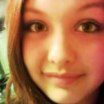

In [ ]:
i = np.random.choice(len(train_dataset))
input_tensor = inv_normalize(train_dataset[i][0])
grid = torchvision.utils.make_grid(input_tensor, nrow=1)
print("Label =",unique_labels[train_dataset[i][1]])
transforms.ToPILImage()(grid)

### Training

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    net = net.cuda()

In [ ]:
print(net)

ResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [ ]:
print("training...")



net.train()
for epoch in range(1, nb_epochs + 1):
    train_loss = []
    val_loss = []
    patience = 0
    best_val_loss = 999

    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        loss = loss_fn(net(x), y)
        loss.backward()

        optimizer.step()

        train_loss.append(loss.item())

    net.eval()
    for x, y in val_dataloader:
        x, y = x.to(device), y.to(device)

        loss = loss_fn(net(x), y)

        val_loss.append(loss.item())

    print("epoch: {}/{}, train loss: {:.3f} | val loss: {:.3f}".format(epoch, nb_epochs, np.mean(train_loss), np.mean(val_loss)))

    if best_val_loss - np.mean(val_loss) > 0.01:
        best_val_loss = np.mean(val_loss)
        patience = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,
            }, '/content/data/outputs/best_model.pth')
        print("val_loss improved. Saved best model")

training...


KeyboardInterrupt: 

### Evaluation

In [ ]:
net = ResNet()
net.load_state_dict(torch.load('/content/data/outputs/best_model.pth')['model_state_dict'])
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    net = net.cuda()
print("loaded best model")

loaded best model


In [ ]:
net.eval()
ys = []
y_preds = []

for x, y in test_dataloader:
    x, y = x.to(device), y.to(device)
    y_pred = net(x)

    ys.append(y.detach().cpu().data.numpy())
    y_preds.append(y_pred.detach().cpu().data.numpy())

In [ ]:
ys = np.concatenate(ys)
y_preds = np.concatenate(y_preds, axis=0).argmax(axis=1)

In [ ]:
print(classification_report(ys, y_preds))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       980
           1       0.84      0.89      0.87       485
           2       0.90      0.87      0.88       324
           3       0.83      0.71      0.77       412

    accuracy                           0.87      2201
   macro avg       0.86      0.85      0.85      2201
weighted avg       0.87      0.87      0.86      2201



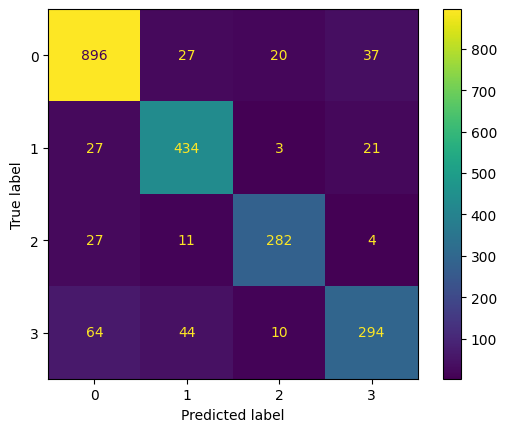

In [ ]:
cm = confusion_matrix(ys, y_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

training...
epoch: 1/30, train loss: 0.732 | val loss: 0.660
val_loss improved. Saved best model
epoch: 2/30, train loss: 0.733 | val loss: 0.579
val_loss improved. Saved best model
epoch: 3/30, train loss: 0.629 | val loss: 0.550
val_loss improved. Saved best model
epoch: 4/30, train loss: 0.585 | val loss: 0.550
val_loss improved. Saved best model
epoch: 5/30, train loss: 0.564 | val loss: 0.603
val_loss improved. Saved best model
epoch: 6/30, train loss: 0.524 | val loss: 0.491
val_loss improved. Saved best model
epoch: 7/30, train loss: 0.490 | val loss: 0.467
val_loss improved. Saved best model
epoch: 8/30, train loss: 0.467 | val loss: 0.462
val_loss improved. Saved best model
epoch: 9/30, train loss: 0.450 | val loss: 0.447
val_loss improved. Saved best model
epoch: 10/30, train loss: 0.432 | val loss: 0.467
val_loss improved. Saved best model
epoch: 11/30, train loss: 0.418 | val loss: 0.420
val_loss improved. Saved best model
epoch: 12/30, train loss: 0.403 | val loss: 0.426
v

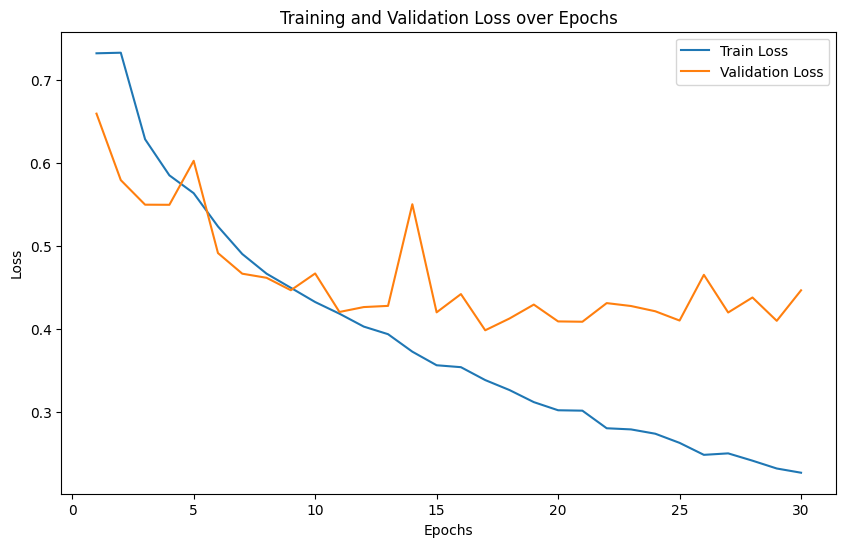

In [ ]:
#2A
import matplotlib.pyplot as plt
import numpy as np


print("training...")

train_losses = []
val_losses = []

net.train()
for epoch in range(1, nb_epochs + 1):
    train_loss = []
    val_loss = []
    patience = 0
    best_val_loss = 999

    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        loss = loss_fn(net(x), y)
        loss.backward()

        optimizer.step()

        train_loss.append(loss.item())

    net.eval()
    for x, y in val_dataloader:
        x, y = x.to(device), y.to(device)

        loss = loss_fn(net(x), y)

        val_loss.append(loss.item())

    avg_train_loss = np.mean(train_loss)
    avg_val_loss = np.mean(val_loss)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print("epoch: {}/{}, train loss: {:.3f} | val loss: {:.3f}".format(epoch, nb_epochs, avg_train_loss, avg_val_loss))

    if best_val_loss - avg_val_loss > 0.01:
        best_val_loss = avg_val_loss
        patience = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,
        }, '/content/data/outputs/best_model.pth')
        print("val_loss improved. Saved best model")

# Plotting the losses
plt.figure(figsize=(10, 6))
epochs = range(1, nb_epochs + 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

training...
epoch: 1/30, train loss: 0.754 | val loss: 0.683
val_loss improved. Saved best model
epoch: 2/30, train loss: 0.651 | val loss: 0.591
val_loss improved. Saved best model
epoch: 3/30, train loss: 0.555 | val loss: 0.539
val_loss improved. Saved best model
epoch: 4/30, train loss: 0.517 | val loss: 0.526
val_loss improved. Saved best model
epoch: 5/30, train loss: 0.489 | val loss: 0.496
val_loss improved. Saved best model
epoch: 6/30, train loss: 0.461 | val loss: 0.473
val_loss improved. Saved best model
epoch: 7/30, train loss: 0.448 | val loss: 0.495
val_loss improved. Saved best model
epoch: 8/30, train loss: 0.433 | val loss: 0.468
val_loss improved. Saved best model
epoch: 9/30, train loss: 0.409 | val loss: 0.453
val_loss improved. Saved best model
epoch: 10/30, train loss: 0.401 | val loss: 0.423
val_loss improved. Saved best model
epoch: 11/30, train loss: 0.385 | val loss: 0.420
val_loss improved. Saved best model
epoch: 12/30, train loss: 0.374 | val loss: 0.527
v

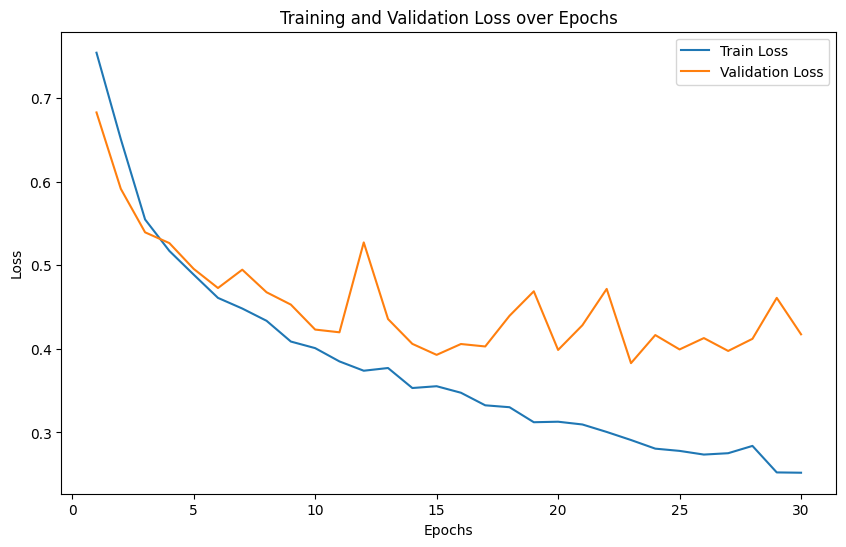

In [ ]:
#2B
lr = 0.01

optimizer = torch.optim.Adam(net.parameters(), lr=lr)


print("training...")

train_losses = []
val_losses = []

net.train()
for epoch in range(1, nb_epochs + 1):
    train_loss = []
    val_loss = []
    patience = 0
    best_val_loss = 999

    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        loss = loss_fn(net(x), y)
        loss.backward()

        optimizer.step()

        train_loss.append(loss.item())

    net.eval()
    for x, y in val_dataloader:
        x, y = x.to(device), y.to(device)

        loss = loss_fn(net(x), y)

        val_loss.append(loss.item())

    avg_train_loss = np.mean(train_loss)
    avg_val_loss = np.mean(val_loss)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print("epoch: {}/{}, train loss: {:.3f} | val loss: {:.3f}".format(epoch, nb_epochs, avg_train_loss, avg_val_loss))

    if best_val_loss - avg_val_loss > 0.01:
        best_val_loss = avg_val_loss
        patience = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,
        }, '/content/data/outputs/best_model.pth')
        print("val_loss improved. Saved best model")

# Plotting the losses
plt.figure(figsize=(10, 6))
epochs = range(1, nb_epochs + 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

training...
epoch: 1/30, train loss: 1.222 | val loss: 1.933
val_loss improved. Saved best model
epoch: 2/30, train loss: 1.570 | val loss: 1.282
val_loss improved. Saved best model
epoch: 3/30, train loss: 1.288 | val loss: 1.282
val_loss improved. Saved best model
epoch: 4/30, train loss: 1.286 | val loss: 1.285
val_loss improved. Saved best model
epoch: 5/30, train loss: 1.288 | val loss: 1.288
val_loss improved. Saved best model
epoch: 6/30, train loss: 1.288 | val loss: 1.284
val_loss improved. Saved best model
epoch: 7/30, train loss: 1.288 | val loss: 1.292
val_loss improved. Saved best model
epoch: 8/30, train loss: 1.287 | val loss: 1.282
val_loss improved. Saved best model
epoch: 9/30, train loss: 1.288 | val loss: 1.282
val_loss improved. Saved best model
epoch: 10/30, train loss: 1.287 | val loss: 1.279
val_loss improved. Saved best model
epoch: 11/30, train loss: 1.289 | val loss: 1.285
val_loss improved. Saved best model
epoch: 12/30, train loss: 1.290 | val loss: 1.286
v

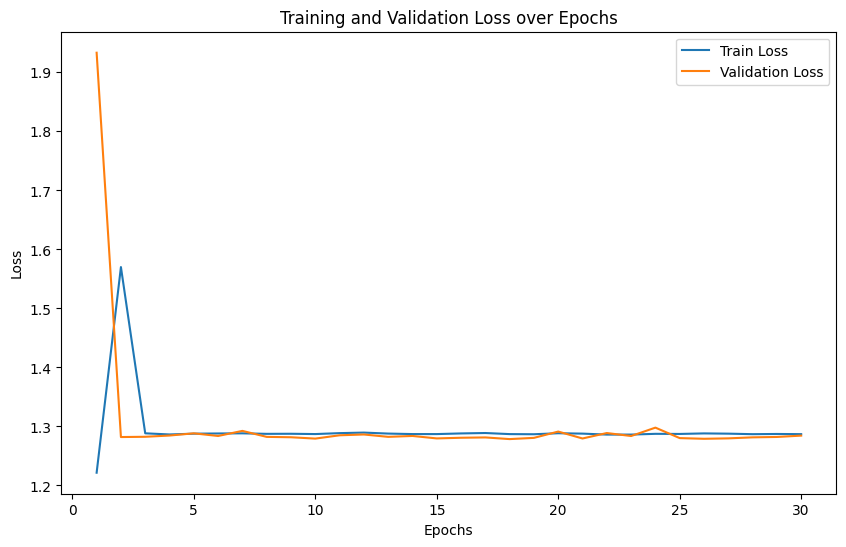

In [ ]:
#2C
lr = 0.1

optimizer = torch.optim.Adam(net.parameters(), lr=lr)


print("training...")

train_losses = []
val_losses = []

net.train()
for epoch in range(1, nb_epochs + 1):
    train_loss = []
    val_loss = []
    patience = 0
    best_val_loss = 999

    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        loss = loss_fn(net(x), y)
        loss.backward()

        optimizer.step()

        train_loss.append(loss.item())

    net.eval()
    for x, y in val_dataloader:
        x, y = x.to(device), y.to(device)

        loss = loss_fn(net(x), y)

        val_loss.append(loss.item())

    avg_train_loss = np.mean(train_loss)
    avg_val_loss = np.mean(val_loss)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print("epoch: {}/{}, train loss: {:.3f} | val loss: {:.3f}".format(epoch, nb_epochs, avg_train_loss, avg_val_loss))

    if best_val_loss - avg_val_loss > 0.01:
        best_val_loss = avg_val_loss
        patience = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,
        }, '/content/data/outputs/best_model.pth')
        print("val_loss improved. Saved best model")

# Plotting the losses
plt.figure(figsize=(10, 6))
epochs = range(1, nb_epochs + 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

As the learning rate becomes larger, our validation loss will stop progressing at an earlier bound. With the 0.001 rate, it approaches a bound of 0.4 for its loss. With the rate of 0.01 it approaches a lower bound a little bit higher than 0.4. The loss appears to be around 0.45 in that case, and holds relatively steady there. In the last case with rate of 0.1, we can observe the bound at a much higher 1.3 for validation loss.

Training loss is more complex to evaluate. We can see in the first graph at 0.001 that it has a relatively smooth and quick descent towards a loss approaching 0. We know that as a model approaches 0 loss in training, it has usually become overfit. The graph allows us to observe this in action. Moving on to the 0.01 graph, we can see the training loss approaching the same 0 value, though this time it does so more slowly. There is a horizontal line at the start which appears to consist of roughly the first epoch, where there is no apparent training loss improvement observed. It then goes down a similar curve as our first graph's training loss, but it clearly has more area under its curve than our prior one. In the last 0.1 graph, we can see that the training loss appears to start close to the bottom, jump, and then sit at a steady, relatively horizontal line for the rest of the epochs.

By the epoch of about 4 in the 0.1 graph, we can see the training and validation loss sitting at about the same value.

As we increase the learning rate, I believe we are observing the program's convergence on a sub-optimal solution. We can see this through the fact that the training and validation curves begin to resemble each other. This means that the rapid changes induced by the large steps in our learning rate caused the program to effectively learn only the surface level complexity of the problem and come to a solution that is equally surface level. Without the ability to make smaller changes, it does not go towards any better understanding of the data we train it on and stays satisfied at this surface level understanding.

In [ ]:
#4
import torch.nn.functional as F

class ResNet(nn.Module): #new
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        self.resnet = models.resnet18(weights=None)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, len(unique_labels))
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
      x = self.dropout(x)
      x = F.relu(x)
      x = self.resnet(x)
      return x


net = ResNet() #new
lr = 0.001
nb_epochs = 30
batch_size = 32
seed = 777
loss_fn = torch.nn.CrossEntropyLoss()
clip_value = 1.0
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    net = net.cuda()

print("training...")

net.train()
for epoch in range(1, nb_epochs + 1):
    train_loss = []
    val_loss = []
    patience = 0
    best_val_loss = 999

    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        loss = loss_fn(net(x), y)

        torch.nn.utils.clip_grad_norm_(net.parameters(), clip_value)

        loss.backward()

        optimizer.step()

        train_loss.append(loss.item())

    net.eval()
    for x, y in val_dataloader:
        x, y = x.to(device), y.to(device)

        loss = loss_fn(net(x), y)

        val_loss.append(loss.item())

    avg_train_loss = np.mean(train_loss)
    avg_val_loss = np.mean(val_loss)


    print("epoch: {}/{}, train loss: {:.3f} | val loss: {:.3f}".format(epoch, nb_epochs, avg_train_loss, avg_val_loss))

    if best_val_loss - avg_val_loss > 0.01:
        best_val_loss = avg_val_loss
        patience = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,
        }, '/content/data/outputs/best_model.pth')
        print("val_loss improved. Saved best model")


training...
epoch: 1/30, train loss: 1.095 | val loss: 1.123
val_loss improved. Saved best model
epoch: 2/30, train loss: 1.014 | val loss: 0.929
val_loss improved. Saved best model
epoch: 3/30, train loss: 0.878 | val loss: 0.815
val_loss improved. Saved best model
epoch: 4/30, train loss: 0.809 | val loss: 0.721
val_loss improved. Saved best model


KeyboardInterrupt: 

In [ ]:
net = ResNet()
net.load_state_dict(torch.load('/content/data/outputs/best_model.pth')['model_state_dict'])
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    net = net.cuda()
print("loaded best model")

In [ ]:
net.eval()
ys = []
y_preds = []

for x, y in test_dataloader:
    x, y = x.to(device), y.to(device)
    y_pred = net(x)

    ys.append(y.detach().cpu().data.numpy())
    y_preds.append(y_pred.detach().cpu().data.numpy())

In [ ]:
ys = np.concatenate(ys)
y_preds = np.concatenate(y_preds, axis=0).argmax(axis=1)

In [ ]:
print(classification_report(ys, y_preds))

In [ ]:
cm = confusion_matrix(ys, y_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

The use of dropout and gradient clipping allows us to prevent our model from overfitting and improve accuracy by regularizing the data. We're using dropout since the set we're working with is relatively small. Dropout is only a bad idea to implement when the set we're working with is astronomically large. Gradient clipping is another good regularization technique that lets us prevent sudden changes, like cliffs in the gradient landscape, from throwing off our model.